# AISE4010 — Assignment 1 
### Time Series Forecasting with Autoregressive Models and MLP 

**Grade:** 100 points

## Instructions
Follow these steps before submitting your assignment:
1. Complete the notebook.
2. Make sure **all plots have axis labels**.
3. When finished, go to **Kernel → Restart & Run All** to ensure a clean, error‑free run.
4. Fix any errors until your notebook runs without problems.
5. Submit **one completed notebook** per group to OWL by the deadline.
6. Reference all external code and documentation you use.

## Dataset 
- **File:** `weather.csv`
- **Location:** Szeged, Hungary
- **Frequency:** Daily (fixed calendar index)
- **Time span:** ≈ 2006–2016
- **Target:** `Temperature (C)`
- **Key variables:** Temperature (C), Pressure (millibars), Humidity, Appar Temperature (C), Wind Speed (km/h), Wind Bearing (degrees), Visibility (km)


## Question 1: Data Preprocessing (25%)

### Q1.1 Exploratory Data Analysis (2%)
1. Load the dataset and print the **first 6 rows**.  
2. Encode categorical variables (one‑hot). *(If none, report "none.")*


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

sns.set(style='whitegrid', context='talk')

data_path = Path('weather.csv')
if not data_path.exists():
    raise FileNotFoundError(f'Could not find {data_path.resolve()}')

daily = pd.read_csv(data_path, parse_dates=['Formatted Date'])
daily = daily.set_index('Formatted Date').sort_index()

subset_cols = ['Temperature (C)', 'Pressure (millibars)', 'Humidity']

display(daily.head(6))

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Formatted Date,,,,,,,
2005-12-31,0.6,-4.0,0.89,17.1,140.0,10.0,1016.7
2006-01-01,4.1,-0.2,0.82,21.2,143.0,11.3,1012.0
2006-01-02,5.3,1.8,0.85,17.8,165.0,8.5,1010.4
2006-01-03,2.3,0.4,0.90,7.7,253.0,9.2,1021.2
2006-01-04,2.3,-0.7,0.91,12.2,35.0,8.4,981.8
2006-01-05,2.7,0.4,0.95,9.0,140.0,4.3,935.9


In [2]:
categorical_cols = daily.select_dtypes(include=['object', 'category']).columns.tolist()
if categorical_cols:
    daily = pd.get_dummies(daily, columns=categorical_cols, drop_first=False)
    print('Encoded columns:', categorical_cols)
else:
    print('Categorical columns to encode: none')

Categorical columns to encode: none


### Q1.2 Handling Missing Data (11%)
1. Report missingness (**counts & %**) and show a heatmap for **Temperature, Pressure, Humidity**.
2. Use these two imputation methods:\
   a) Forward-fill (FFill).\
   b) Linear time interpolation.
3. Pick one method and save the result as `daily_clean`.
4. **Discussion** Which imputation method did you pick and why?  
5. **Discussion** How might your choice bias trend/seasonality estimates?  
6. **Discussion** Would your choice change if the gap were 30 days instead of 7? Explain briefly.


In [3]:
missing_counts = daily.isna().sum()
missing_percent = (missing_counts / len(daily)) * 100
missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_percent': missing_percent.round(2)
}).sort_values('missing_count', ascending=False)
missing_summary

,missing_count,missing_percent
Temperature (C),47,1.17
Pressure (millibars),47,1.17
Humidity,40,1.00
Apparent Temperature (C),0,0.00
Wind Speed (km/h),0,0.00
Wind Bearing (degrees),0,0.00
Visibility (km),0,0.00


/tmp/ipykernel_4801/3108051132.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


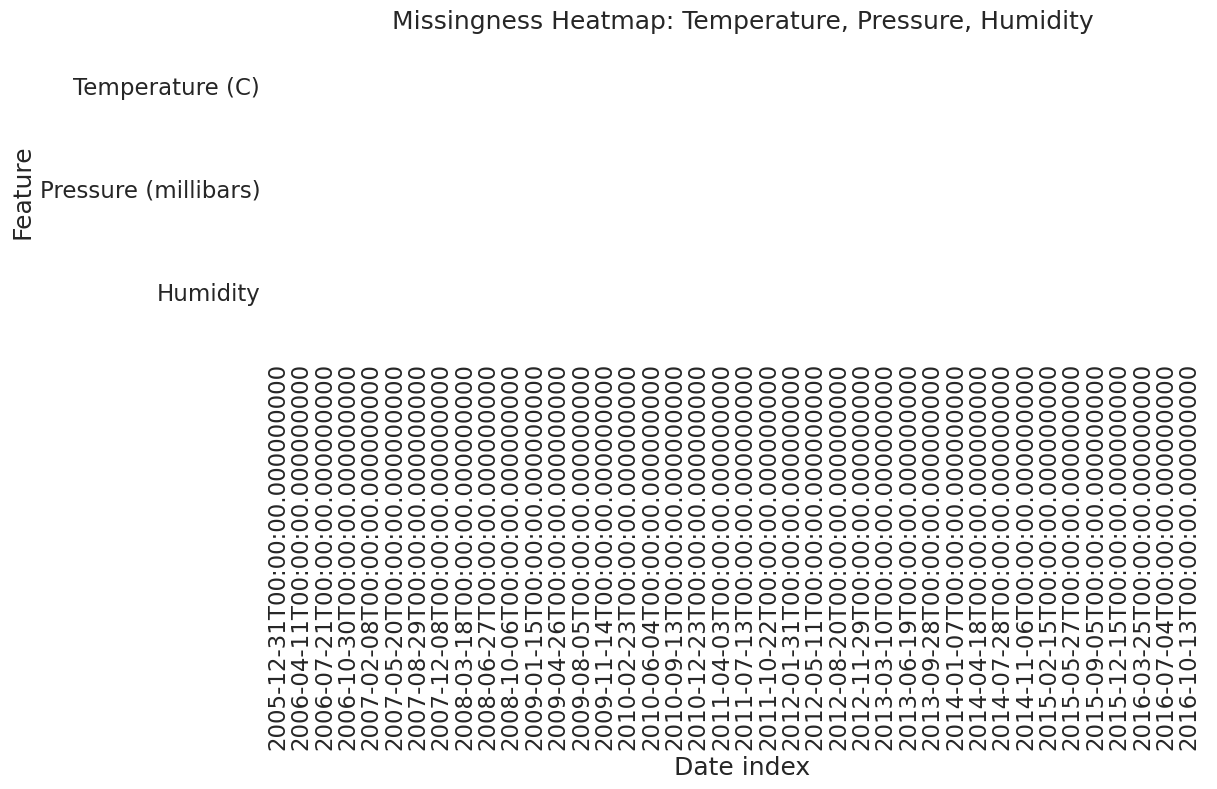

In [4]:
subset_cols = ['Temperature (C)', 'Pressure (millibars)', 'Humidity']
plt.figure(figsize=(12, 4))
sns.heatmap(daily[subset_cols].isna().T, cbar=False, cmap='viridis', linewidths=0.5)
plt.title('Missingness Heatmap: Temperature, Pressure, Humidity')
plt.xlabel('Date index')
plt.ylabel('Feature')
plt.tight_layout()

In [5]:
subset_cols = ['Temperature (C)', 'Pressure (millibars)', 'Humidity']
ffill_imputed = daily[subset_cols].ffill().bfill()
linear_imputed = daily[subset_cols].interpolate(method='time').ffill().bfill()

imputation_summary = pd.DataFrame({
    'ffill_remaining_na': ffill_imputed.isna().sum(),
    'linear_remaining_na': linear_imputed.isna().sum()
})
imputation_summary

,ffill_remaining_na,linear_remaining_na
Temperature (C),0,0
Pressure (millibars),0,0
Humidity,0,0


**Answer to Q1.2.4**: 


**Answer to Q1.2.5**: 


**Answer to Q1.2.6**: 


### Q1.3 Stationarity Analysis (12%)
1. Extract the **univariate** series `Temperature_Series = daily_clean['Temperature (C)']` and `Pressure_Series = daily_clean['Pressure (millibars)'].  
2. Report the results of a stationarity test (**ADF** or **KPSS**) for both series.
3. **Discussion:** Explain your conclusion about stationary analysis of your results. 
4. Apply differencing on both series and plot **before/after** and report the stationary test results of your choice on differenced series.   
5. **Discussion:** Explain the reason for your choice of differencing technique for each series.
6. **Discussion:** Would you difference a series that is already stationary by ADF? When might that still help?

In [6]:
daily_clean = daily.copy()
daily_clean[subset_cols] = linear_imputed

Temperature_Series = daily_clean['Temperature (C)']
Pressure_Series = daily_clean['Pressure (millibars)']

pd.DataFrame({
    'Temperature_head': Temperature_Series.head(3),
    'Pressure_head': Pressure_Series.head(3)
})

,Temperature_head,Pressure_head
Formatted Date,,
2005-12-31,0.6,1016.7
2006-01-01,4.1,1012.0
2006-01-02,5.3,1010.4


In [7]:
from statsmodels.tsa.stattools import adfuller

def adf_report(series, name):
    result = adfuller(series.dropna(), autolag='AIC')
    output = {
        'Series': name,
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Observations': result[3]
    }
    return output

temp_adf = adf_report(Temperature_Series, 'Temperature (C)')
press_adf = adf_report(Pressure_Series, 'Pressure (millibars)')
pd.DataFrame([temp_adf, press_adf])

,Series,ADF Statistic,p-value,Lags Used,Observations
0,Temperature (C),-3.985160,1.490241e-03,16,4002
1,Pressure (millibars),-14.320986,1.141389e-26,5,4013


**Answer to Q1.2.3**: 


,Series,ADF Statistic,p-value,Lags Used,Observations
0,Temperature (C) — First Difference,-21.527852,0.000000e+00,15,4002
1,Pressure (millibars) — First Difference,-16.503540,2.137737e-29,31,3986


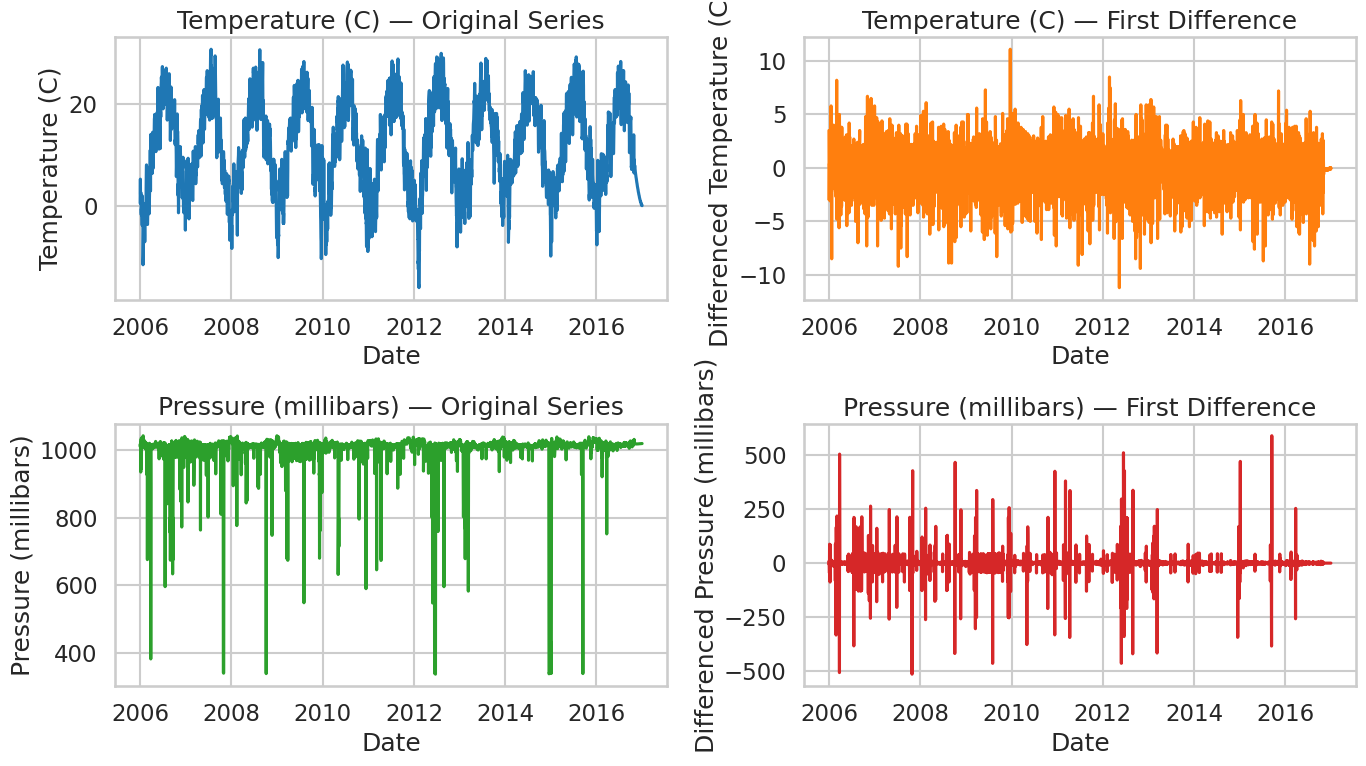

In [8]:
temp_diff = Temperature_Series.diff().dropna()
press_diff = Pressure_Series.diff().dropna()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes[0, 0].plot(Temperature_Series, color='tab:blue')
axes[0, 0].set_title('Temperature (C) — Original Series')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Temperature (C)')
axes[0, 1].plot(temp_diff, color='tab:orange')
axes[0, 1].set_title('Temperature (C) — First Difference')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Differenced Temperature (C)')
axes[1, 0].plot(Pressure_Series, color='tab:green')
axes[1, 0].set_title('Pressure (millibars) — Original Series')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Pressure (millibars)')
axes[1, 1].plot(press_diff, color='tab:red')
axes[1, 1].set_title('Pressure (millibars) — First Difference')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Differenced Pressure (millibars)')
plt.tight_layout()

from statsmodels.tsa.stattools import adfuller

def adf_report(series, name):
    result = adfuller(series.dropna(), autolag='AIC')
    output = {
        'Series': name,
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Observations': result[3]
    }
    return output

temp_diff_adf = adf_report(temp_diff, 'Temperature (C) — First Difference')
press_diff_adf = adf_report(press_diff, 'Pressure (millibars) — First Difference')
pd.DataFrame([temp_diff_adf, press_diff_adf])

**Answer to Q1.2.5**: 


**Answer to Q1.2.6**: 


## Question 2: Model-Based Techniques (35%)

### Q2.1 ARIMA model identification and forecasting (20%)
1. Use `Temperature_Series` to plot **ACF/PACF** and list the choice of candidate order set for ARIMA: (p,d,q).  
2. **Discussion:** Explain the reasons for your choice of (p,d,q).
3. Select the orders by **AIC** using the training set (hold out the last **365 days** for testing).  
4. Fit the selected ARIMA on the training set and evaluate the predictions' **MAE/MSE** on the test set.
5. Plot predictions with **95% CI**.
6. Forecast the **next 365 days** and visualize with historical context and **95% CI**.


Candidate ARIMA orders (p, d, q): [(1, 1, 1), (2, 1, 1), (1, 1, 2), (2, 1, 2), (3, 1, 1)]


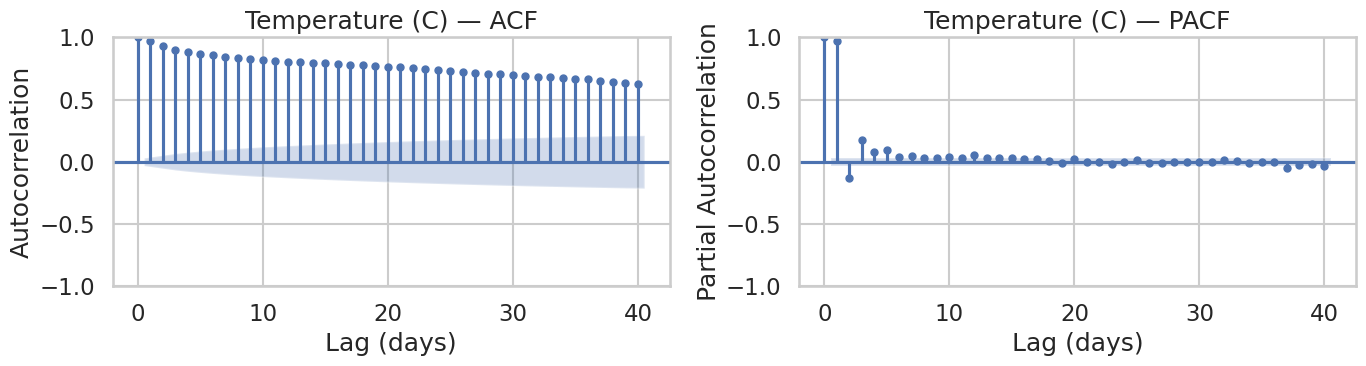

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(Temperature_Series, ax=axes[0], lags=40)
axes[0].set_title('Temperature (C) — ACF')
axes[0].set_xlabel('Lag (days)')
axes[0].set_ylabel('Autocorrelation')
plot_pacf(Temperature_Series, ax=axes[1], lags=40, method='ywm')
axes[1].set_title('Temperature (C) — PACF')
axes[1].set_xlabel('Lag (days)')
axes[1].set_ylabel('Partial Autocorrelation')
plt.tight_layout()

candidate_orders = [(1, 1, 1), (2, 1, 1), (1, 1, 2), (2, 1, 2), (3, 1, 1)]
print('Candidate ARIMA orders (p, d, q):', candidate_orders)

**Answer to Q2.1.2**: 


In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

train_size = len(Temperature_Series) - 365
train_temp = Temperature_Series.iloc[:train_size]
test_temp = Temperature_Series.iloc[train_size:]

aic_records = []
for order in candidate_orders:
    try:
        model = SARIMAX(train_temp, order=order, enforce_stationarity=False, enforce_invertibility=False)
        result = model.fit(disp=False)
        aic_records.append({'order': order, 'AIC': result.aic})
    except Exception as exc:
        aic_records.append({'order': order, 'AIC': np.nan, 'error': str(exc)})

aic_table = pd.DataFrame(aic_records).sort_values('AIC')
best_arima_order = tuple(aic_table.iloc[0]['order'])
print('Best ARIMA order by AIC:', best_arima_order)
aic_table

/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Best ARIMA order by AIC: (1, 1, 2)


,order,AIC
2,"(1, 1, 2)",15830.878832
3,"(2, 1, 2)",15832.567798
4,"(3, 1, 1)",15834.782291
1,"(2, 1, 1)",15851.015393
0,"(1, 1, 1)",16042.665375


In [11]:
arima_model = SARIMAX(train_temp, order=best_arima_order, enforce_stationarity=False, enforce_invertibility=False)
arima_result = arima_model.fit(disp=False)

test_forecast = arima_result.get_forecast(steps=len(test_temp))
test_pred_mean = test_forecast.predicted_mean
test_pred_ci = test_forecast.conf_int(alpha=0.05)

arima_mae = mean_absolute_error(test_temp, test_pred_mean)
arima_mse = mean_squared_error(test_temp, test_pred_mean)
arima_rmse = np.sqrt(arima_mse)

pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE'],
    'Value': [arima_mae, arima_mse, arima_rmse]
})

/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,Metric,Value
0,MAE,13.383861
1,MSE,242.402800
2,RMSE,15.569290


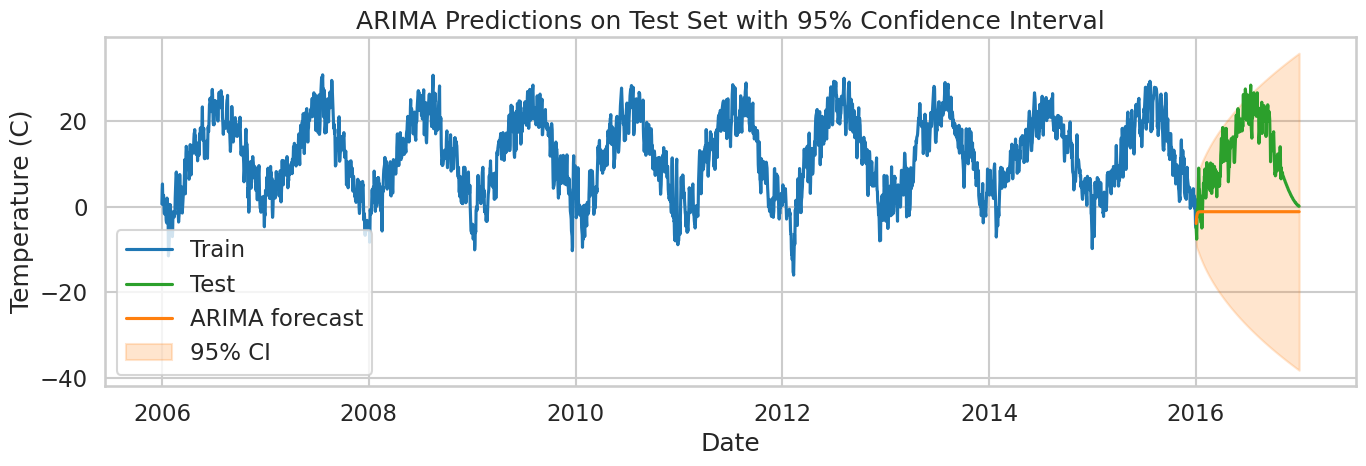

In [12]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_temp.index, train_temp, label='Train', color='tab:blue')
ax.plot(test_temp.index, test_temp, label='Test', color='tab:green')
ax.plot(test_pred_mean.index, test_pred_mean, label='ARIMA forecast', color='tab:orange')
ax.fill_between(test_pred_ci.index, test_pred_ci.iloc[:, 0], test_pred_ci.iloc[:, 1], color='tab:orange', alpha=0.2, label='95% CI')
ax.set_title('ARIMA Predictions on Test Set with 95% Confidence Interval')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (C)')
ax.legend()
plt.tight_layout()

/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


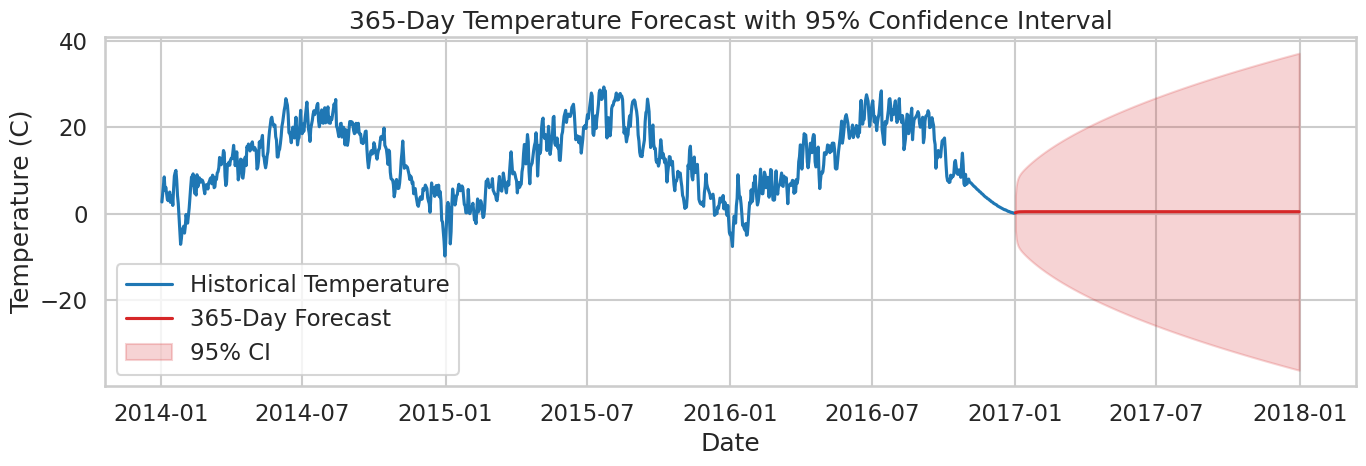

In [13]:
full_model = SARIMAX(Temperature_Series, order=best_arima_order, enforce_stationarity=False, enforce_invertibility=False)
full_result = full_model.fit(disp=False)

forecast_steps = 365
future_forecast = full_result.get_forecast(steps=forecast_steps)
future_mean = future_forecast.predicted_mean
future_ci = future_forecast.conf_int(alpha=0.05)

fig, ax = plt.subplots(figsize=(14, 5))
history_to_plot = Temperature_Series.iloc[-(365 * 3):]
ax.plot(history_to_plot.index, history_to_plot, label='Historical Temperature', color='tab:blue')
ax.plot(future_mean.index, future_mean, label='365-Day Forecast', color='tab:red')
ax.fill_between(future_ci.index, future_ci.iloc[:, 0], future_ci.iloc[:, 1], color='tab:red', alpha=0.2, label='95% CI')
ax.set_title('365-Day Temperature Forecast with 95% Confidence Interval')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (C)')
ax.legend()
plt.tight_layout()

### Q2.2 SARIMA forecasting (15%)

1. Derive a **monthly** series from `daily_clean` and fit a **SARIMA** with seasonal period **12**. Hold out the **last 24 months** as test set for prediction. 
2. Report the predictions' **MAE/MSE**.
3. Plot the the prediction with **95% CI** 
4.  **Discussion:** Compare the ARIMA and SARIMA predictions and explain your findings.


In [14]:
monthly_temp = daily_clean['Temperature (C)'].resample('MS').mean()
train_months = monthly_temp.iloc[:-24]
test_months = monthly_temp.iloc[-24:]

non_seasonal_orders = [(0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)]
seasonal_orders = [(0, 1, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]

sarima_results = []
for order in non_seasonal_orders:
    for seasonal_order in seasonal_orders:
        try:
            sarima_model = SARIMAX(train_months, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
            sarima_fit = sarima_model.fit(disp=False)
            sarima_results.append({
                'order': order,
                'seasonal_order': seasonal_order,
                'AIC': sarima_fit.aic
            })
        except Exception as exc:
            sarima_results.append({
                'order': order,
                'seasonal_order': seasonal_order,
                'AIC': np.nan,
                'error': str(exc)
            })

sarima_table = pd.DataFrame(sarima_results).sort_values('AIC')
best_sarima_order = tuple(sarima_table.iloc[0]['order'])
best_sarima_seasonal = tuple(sarima_table.iloc[0]['seasonal_order'])
print('Best SARIMA order:', best_sarima_order)
print('Best seasonal order:', best_sarima_seasonal)
sarima_table

Best SARIMA order: (0, 1, 1)
Best seasonal order: (0, 1, 1, 12)


,order,seasonal_order,AIC
0,"(0, 1, 1)","(0, 1, 1, 12)",338.864644
6,"(1, 1, 1)","(0, 1, 1, 12)",340.461577
9,"(2, 1, 1)","(0, 1, 1, 12)",343.977691
8,"(1, 1, 1)","(1, 1, 1, 12)",358.078733
2,"(0, 1, 1)","(1, 1, 1, 12)",358.192971
11,"(2, 1, 1)","(1, 1, 1, 12)",359.923907
10,"(2, 1, 1)","(1, 1, 0, 12)",367.177332
7,"(1, 1, 1)","(1, 1, 0, 12)",370.575907
1,"(0, 1, 1)","(1, 1, 0, 12)",372.950788
3,"(1, 1, 0)","(0, 1, 1, 12)",376.088469


In [15]:
sarima_model = SARIMAX(train_months, order=best_sarima_order, seasonal_order=best_sarima_seasonal, enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)

monthly_forecast = sarima_result.get_forecast(steps=len(test_months))
monthly_pred_mean = monthly_forecast.predicted_mean
monthly_pred_ci = monthly_forecast.conf_int(alpha=0.05)

sarima_mae = mean_absolute_error(test_months, monthly_pred_mean)
sarima_mse = mean_squared_error(test_months, monthly_pred_mean)
sarima_rmse = np.sqrt(sarima_mse)

pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE'],
    'Value': [sarima_mae, sarima_mse, sarima_rmse]
})

,Metric,Value
0,MAE,0.958473
1,MSE,1.700693
2,RMSE,1.304106


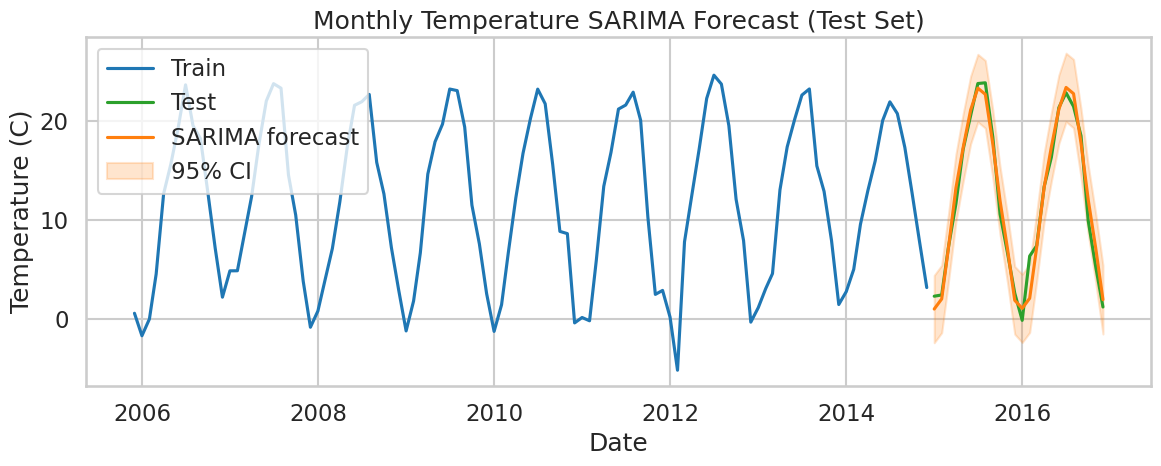

In [16]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(train_months.index, train_months, label='Train', color='tab:blue')
ax.plot(test_months.index, test_months, label='Test', color='tab:green')
ax.plot(monthly_pred_mean.index, monthly_pred_mean, label='SARIMA forecast', color='tab:orange')
ax.fill_between(monthly_pred_ci.index, monthly_pred_ci.iloc[:, 0], monthly_pred_ci.iloc[:, 1], color='tab:orange', alpha=0.2, label='95% CI')
ax.set_title('Monthly Temperature SARIMA Forecast (Test Set)')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (C)')
ax.legend()
plt.tight_layout()

**Answer to Q2.2.4**: 


## Question 3: Neural Networks for Time Series Forecasting (40%)
Use `daily_clean` for all parts.

### Q3.1 Sliding Window for Time Series — Univariate (2%)
1. Restructure **Temperature**: past **10 days** → **next day**.

2. Hold out last 20% as test set.


In [17]:
WINDOW_SIZE = 10
HORIZON = 1

def create_univariate_sequences(series, window):
    values = series.values.astype(float)
    X, y = [], []
    for idx in range(window, len(values)):
        X.append(values[idx - window:idx])
        y.append(values[idx])
    return np.array(X), np.array(y)

X_univariate, y_univariate = create_univariate_sequences(Temperature_Series, WINDOW_SIZE)
split_idx = int(len(X_univariate) * 0.8)
X_train_uni, X_test_uni = X_univariate[:split_idx], X_univariate[split_idx:]
y_train_uni, y_test_uni = y_univariate[:split_idx], y_univariate[split_idx:]

X_train_uni.shape, X_test_uni.shape

((3207, 10), (802, 10))

In [18]:
print(f'Univariate training samples: {X_train_uni.shape[0]}, testing samples: {X_test_uni.shape[0]}')
print(f'Input window size: {X_train_uni.shape[1]} days')

Univariate training samples: 3207, testing samples: 802
Input window size: 10 days


### Q3.2 MLP — Univariate (18%)
1. Build an MLP with one hidden layer of 64 neurons, ReLu activation, Adam optimizer with learning rate of 0.001 and batch_size=32, and train it for 20 epochs. 
2. Report **RMSE/MAE**.
3. Plot **two figures**: (1) **last 100 test points** (true vs. predicted), (2) **scatter (true vs. predicted)** with the **y = x** line.
4. **Discussion:** Compare ARIMA vs. the univariate MLP in **RMSE/MAE** and **plots**. Which patterns does each capture better? 
5. **Discussion:** Would increasing the input window beyond 10 days help? Why or why not?


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

uni_scaler = StandardScaler()
X_train_uni_scaled = uni_scaler.fit_transform(X_train_uni)
X_test_uni_scaled = uni_scaler.transform(X_test_uni)

mlp_univariate = MLPRegressor(hidden_layer_sizes=(64,), activation='relu', solver='adam', learning_rate_init=0.001, batch_size=32, max_iter=20, shuffle=False, random_state=42, verbose=False)
mlp_univariate.fit(X_train_uni_scaled, y_train_uni)

/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


,loss,'squared_error'
,hidden_layer_sizes,"(64,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,32
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,20
,shuffle,False


In [20]:
y_train_uni_pred = mlp_univariate.predict(X_train_uni_scaled)
y_test_uni_pred = mlp_univariate.predict(X_test_uni_scaled)

uni_mae = mean_absolute_error(y_test_uni, y_test_uni_pred)
uni_rmse = np.sqrt(mean_squared_error(y_test_uni, y_test_uni_pred))

pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'MAE': [mean_absolute_error(y_train_uni, y_train_uni_pred), uni_mae],
    'RMSE': [np.sqrt(mean_squared_error(y_train_uni, y_train_uni_pred)), uni_rmse]
})

,Dataset,MAE,RMSE
0,Train,1.790864,2.277140
1,Test,1.656817,2.159017


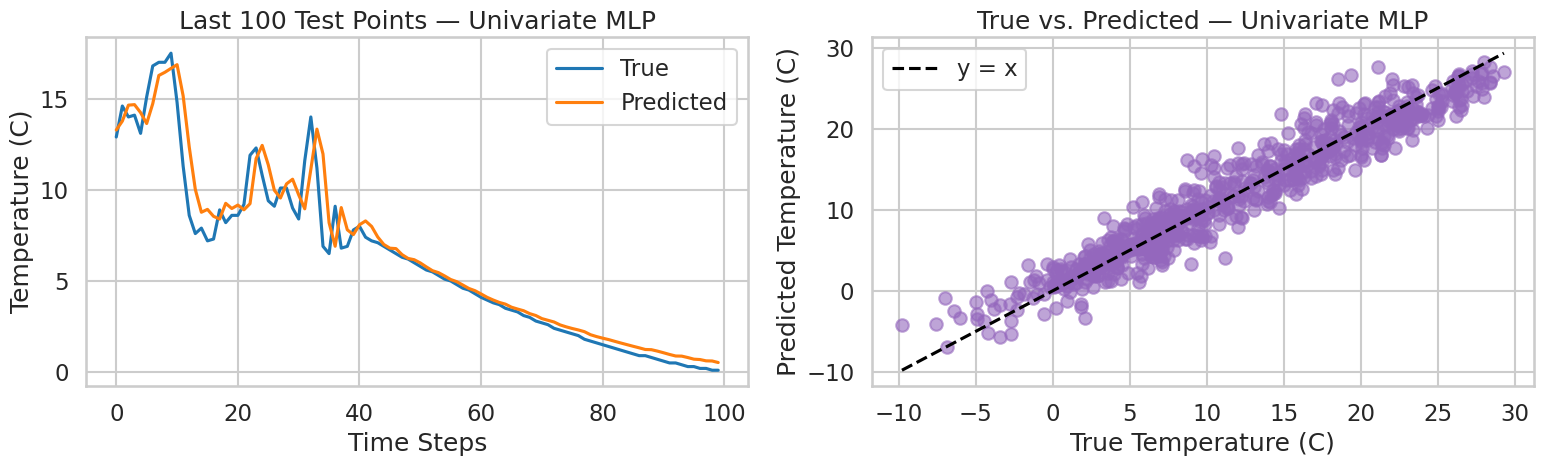

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
last_points = 100
axes[0].plot(y_test_uni[-last_points:], label='True', color='tab:blue')
axes[0].plot(y_test_uni_pred[-last_points:], label='Predicted', color='tab:orange')
axes[0].set_title('Last 100 Test Points — Univariate MLP')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Temperature (C)')
axes[0].legend()

axes[1].scatter(y_test_uni, y_test_uni_pred, alpha=0.6, color='tab:purple')
min_val = min(y_test_uni.min(), y_test_uni_pred.min())
max_val = max(y_test_uni.max(), y_test_uni_pred.max())
axes[1].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='y = x')
axes[1].set_title('True vs. Predicted — Univariate MLP')
axes[1].set_xlabel('True Temperature (C)')
axes[1].set_ylabel('Predicted Temperature (C)')
axes[1].legend()
plt.tight_layout()

**Answer to Q3.2.4**: 


**Answer to Q3.2.5**: 


### Q3.3 MLP — Multivariate (20%)
1. Use **Temperature & Pressure** for the past **10 days** as the inputs and **next‑day Temperature** as the target. 
2. Hold out last 20% as test set.
3. Build a Multivariate MLP with one hidden layer of 64 neurons, ReLu activation, Adam optimizer with learning rate of 0.001 and batch_size=32, and train it for 20 epochs. 
4. Report **RMSE/MAE**.
5. Plot **two figures**: (1) **last 100 test points** (true vs. predicted), (2) **scatter (true vs. predicted)** with the **y = x** line.
6. **Discussion:** Did Pressure improve Temperature forecasting vs. univariate? Why might it help/hurt?  
7. **Discussion:** Suggest two additional features you would add next and why?


In [22]:
multivariate_features = daily_clean[['Temperature (C)', 'Pressure (millibars)']]

def create_multivariate_sequences(values, target_index, window):
    array = values.astype(float)
    X, y = [], []
    for idx in range(window, len(array)):
        X.append(array[idx - window:idx])
        y.append(array[idx, target_index])
    return np.array(X), np.array(y)

X_multivariate, y_multivariate = create_multivariate_sequences(multivariate_features.values, target_index=0, window=WINDOW_SIZE)
split_idx_multi = int(len(X_multivariate) * 0.8)
X_train_multi, X_test_multi = X_multivariate[:split_idx_multi], X_multivariate[split_idx_multi:]
y_train_multi, y_test_multi = y_multivariate[:split_idx_multi], y_multivariate[split_idx_multi:]

X_train_multi.shape, X_test_multi.shape

((3207, 10, 2), (802, 10, 2))

In [23]:
X_train_multi_flat = X_train_multi.reshape(X_train_multi.shape[0], -1)
X_test_multi_flat = X_test_multi.reshape(X_test_multi.shape[0], -1)

multi_scaler = StandardScaler()
X_train_multi_scaled = multi_scaler.fit_transform(X_train_multi_flat)
X_test_multi_scaled = multi_scaler.transform(X_test_multi_flat)

mlp_multivariate = MLPRegressor(hidden_layer_sizes=(64,), activation='relu', solver='adam', learning_rate_init=0.001, batch_size=32, max_iter=20, shuffle=False, random_state=42, verbose=False)
mlp_multivariate.fit(X_train_multi_scaled, y_train_multi)

/root/.pyenv/versions/3.11.12/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


,loss,'squared_error'
,hidden_layer_sizes,"(64,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,32
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,20
,shuffle,False


In [24]:
y_train_multi_pred = mlp_multivariate.predict(X_train_multi_scaled)
y_test_multi_pred = mlp_multivariate.predict(X_test_multi_scaled)

multi_mae = mean_absolute_error(y_test_multi, y_test_multi_pred)
multi_rmse = np.sqrt(mean_squared_error(y_test_multi, y_test_multi_pred))

pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'MAE': [mean_absolute_error(y_train_multi, y_train_multi_pred), multi_mae],
    'RMSE': [np.sqrt(mean_squared_error(y_train_multi, y_train_multi_pred)), multi_rmse]
})

,Dataset,MAE,RMSE
0,Train,1.939323,2.442985
1,Test,1.883089,2.630444


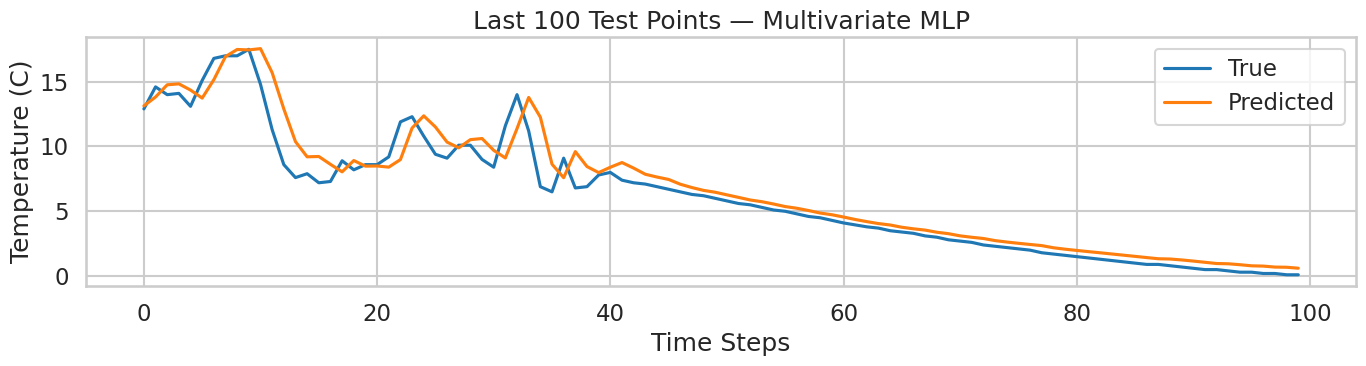

In [25]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_test_multi[-last_points:], label='True', color='tab:blue')
ax.plot(y_test_multi_pred[-last_points:], label='Predicted', color='tab:orange')
ax.set_title('Last 100 Test Points — Multivariate MLP')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Temperature (C)')
ax.legend()
plt.tight_layout()

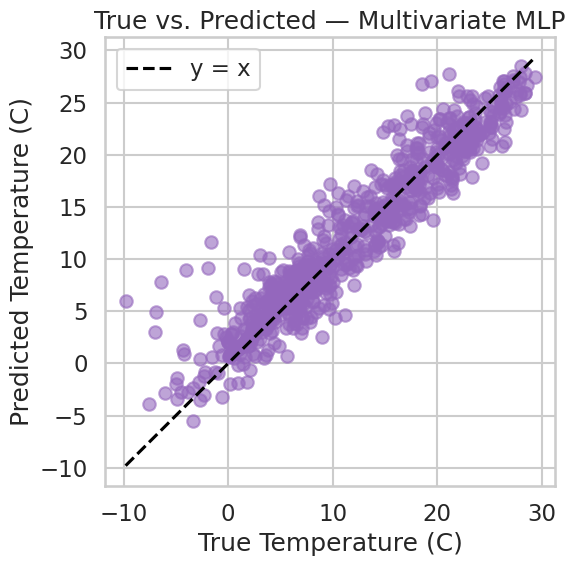

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_test_multi, y_test_multi_pred, alpha=0.6, color='tab:purple')
min_val_multi = min(y_test_multi.min(), y_test_multi_pred.min())
max_val_multi = max(y_test_multi.max(), y_test_multi_pred.max())
ax.plot([min_val_multi, max_val_multi], [min_val_multi, max_val_multi], color='black', linestyle='--', label='y = x')
ax.set_title('True vs. Predicted — Multivariate MLP')
ax.set_xlabel('True Temperature (C)')
ax.set_ylabel('Predicted Temperature (C)')
ax.legend()
plt.tight_layout()

**Answer to Q3.3.6**: 


**Answer to Q3.3.7**: 
